In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 20))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

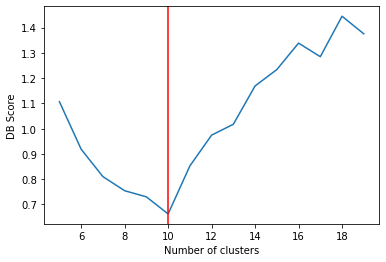

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

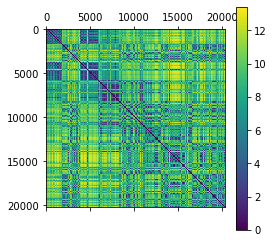

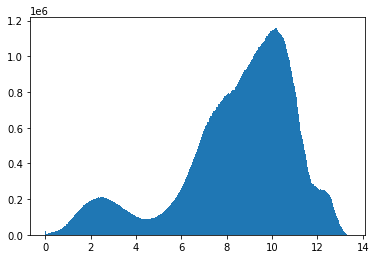

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

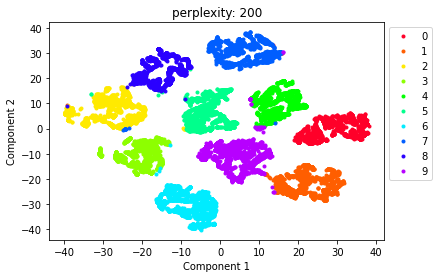

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9745232346129207


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=3)
        

Average sparseness: 0.5584660383490413
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7108080110497237
layer 6: 0.587189226519337
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.298 | Reg loss: 0.016 | Tree loss: 2.298 | Accuracy: 0.095500 | 0.816 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.284 | Reg loss: 0.016 | Tree loss: 2.284 | Accuracy: 0.120500 | 0.628 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.276 | Reg loss: 0.016 | Tree loss: 2.276 | Accuracy: 0.118000 | 0.549 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.267 | Reg loss: 0.016 | Tree loss: 2.267 | Accuracy: 0.290500 | 0.511 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.255 | Reg loss: 0.016 | Tree loss: 2.255 | Accuracy: 0.416500 | 0.489 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.251 | Reg loss: 0.016 | Tree loss: 2.251 | Accuracy: 0.368500 | 0.472 sec/iter
Epoch: 00 | Batch: 006 / 0

Epoch: 05 | Batch: 000 / 011 | Total loss: 2.243 | Reg loss: 0.015 | Tree loss: 2.243 | Accuracy: 0.327500 | 0.488 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.226 | Reg loss: 0.015 | Tree loss: 2.226 | Accuracy: 0.447000 | 0.488 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 2.207 | Reg loss: 0.015 | Tree loss: 2.207 | Accuracy: 0.459000 | 0.489 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 2.190 | Reg loss: 0.015 | Tree loss: 2.190 | Accuracy: 0.439000 | 0.489 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.166 | Reg loss: 0.016 | Tree loss: 2.166 | Accuracy: 0.451000 | 0.488 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.141 | Reg loss: 0.016 | Tree loss: 2.141 | Accuracy: 0.462000 | 0.486 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 2.128 | Reg loss: 0.016 | Tree loss: 2.128 | Accuracy: 0.455000 | 0.486 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 2.104 | Reg loss: 0.016 | Tree loss: 2.104 | Accuracy: 0.466000 | 0.485 sec/iter
Epoch: 0

Epoch: 10 | Batch: 002 / 011 | Total loss: 2.100 | Reg loss: 0.018 | Tree loss: 2.100 | Accuracy: 0.418500 | 0.5 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 2.061 | Reg loss: 0.018 | Tree loss: 2.061 | Accuracy: 0.481500 | 0.5 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 2.019 | Reg loss: 0.018 | Tree loss: 2.019 | Accuracy: 0.491500 | 0.5 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.987 | Reg loss: 0.018 | Tree loss: 1.987 | Accuracy: 0.437000 | 0.499 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 1.944 | Reg loss: 0.019 | Tree loss: 1.944 | Accuracy: 0.442500 | 0.498 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 1.923 | Reg loss: 0.019 | Tree loss: 1.923 | Accuracy: 0.398000 | 0.498 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 1.911 | Reg loss: 0.019 | Tree loss: 1.911 | Accuracy: 0.401500 | 0.498 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.892 | Reg loss: 0.020 | Tree loss: 1.892 | Accuracy: 0.393500 | 0.498 sec/iter
Epoch: 10 | Ba

Epoch: 15 | Batch: 004 / 011 | Total loss: 1.848 | Reg loss: 0.021 | Tree loss: 1.848 | Accuracy: 0.506000 | 0.499 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.801 | Reg loss: 0.021 | Tree loss: 1.801 | Accuracy: 0.500000 | 0.499 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 1.772 | Reg loss: 0.021 | Tree loss: 1.772 | Accuracy: 0.482500 | 0.5 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 1.751 | Reg loss: 0.022 | Tree loss: 1.751 | Accuracy: 0.489000 | 0.5 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 1.710 | Reg loss: 0.022 | Tree loss: 1.710 | Accuracy: 0.474500 | 0.499 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 1.704 | Reg loss: 0.022 | Tree loss: 1.704 | Accuracy: 0.467000 | 0.499 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 1.682 | Reg loss: 0.022 | Tree loss: 1.682 | Accuracy: 0.484642 | 0.5 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.98342

Epoch: 20 | Batch: 006 / 011 | Total loss: 1.638 | Reg loss: 0.024 | Tree loss: 1.638 | Accuracy: 0.553500 | 0.498 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 1.603 | Reg loss: 0.024 | Tree loss: 1.603 | Accuracy: 0.551500 | 0.497 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 1.587 | Reg loss: 0.024 | Tree loss: 1.587 | Accuracy: 0.536000 | 0.497 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 1.565 | Reg loss: 0.024 | Tree loss: 1.565 | Accuracy: 0.550000 | 0.496 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 1.550 | Reg loss: 0.024 | Tree loss: 1.550 | Accuracy: 0.494881 | 0.497 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 21 | Batch: 000 / 011 | Total loss: 1.892 | Reg loss: 0.023 | Tree loss: 1.892 | Accuracy: 0.344000 | 0.497 sec/iter
Epoch: 21 | Batch: 001

Epoch: 25 | Batch: 008 / 011 | Total loss: 1.480 | Reg loss: 0.026 | Tree loss: 1.480 | Accuracy: 0.551500 | 0.489 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 1.456 | Reg loss: 0.026 | Tree loss: 1.456 | Accuracy: 0.556500 | 0.49 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 1.436 | Reg loss: 0.026 | Tree loss: 1.436 | Accuracy: 0.604096 | 0.49 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 26 | Batch: 000 / 011 | Total loss: 1.773 | Reg loss: 0.025 | Tree loss: 1.773 | Accuracy: 0.365000 | 0.49 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 1.718 | Reg loss: 0.025 | Tree loss: 1.718 | Accuracy: 0.403500 | 0.491 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 1.645 | Reg loss: 0.025 | Tree loss: 1.645 | Accuracy: 0.488000 | 0.491 sec/iter
Epoch: 26 | Batch: 003 / 

Epoch: 30 | Batch: 010 / 011 | Total loss: 1.331 | Reg loss: 0.027 | Tree loss: 1.331 | Accuracy: 0.617747 | 0.497 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 31 | Batch: 000 / 011 | Total loss: 1.659 | Reg loss: 0.027 | Tree loss: 1.659 | Accuracy: 0.373000 | 0.497 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 1.619 | Reg loss: 0.027 | Tree loss: 1.619 | Accuracy: 0.425500 | 0.497 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 1.557 | Reg loss: 0.027 | Tree loss: 1.557 | Accuracy: 0.471500 | 0.497 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 1.505 | Reg loss: 0.027 | Tree loss: 1.505 | Accuracy: 0.550500 | 0.496 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.027 | Tree loss: 1.470 | Accuracy: 0.563500 | 0.496 sec/iter
Epoch: 31 | Batch: 005

Epoch: 36 | Batch: 000 / 011 | Total loss: 1.588 | Reg loss: 0.028 | Tree loss: 1.588 | Accuracy: 0.405500 | 0.495 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 1.536 | Reg loss: 0.028 | Tree loss: 1.536 | Accuracy: 0.479000 | 0.494 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 1.470 | Reg loss: 0.028 | Tree loss: 1.470 | Accuracy: 0.583000 | 0.494 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 1.415 | Reg loss: 0.028 | Tree loss: 1.415 | Accuracy: 0.637000 | 0.494 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 1.384 | Reg loss: 0.028 | Tree loss: 1.384 | Accuracy: 0.620500 | 0.494 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 1.365 | Reg loss: 0.028 | Tree loss: 1.365 | Accuracy: 0.594500 | 0.495 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 1.359 | Reg loss: 0.028 | Tree loss: 1.359 | Accuracy: 0.576500 | 0.495 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 1.327 | Reg loss: 0.028 | Tree loss: 1.327 | Accuracy: 0.602000 | 0.495 sec/iter
Epoch: 3

Epoch: 41 | Batch: 002 / 011 | Total loss: 1.427 | Reg loss: 0.029 | Tree loss: 1.427 | Accuracy: 0.576500 | 0.492 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 1.362 | Reg loss: 0.029 | Tree loss: 1.362 | Accuracy: 0.624000 | 0.492 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 1.347 | Reg loss: 0.029 | Tree loss: 1.347 | Accuracy: 0.604000 | 0.492 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 1.289 | Reg loss: 0.029 | Tree loss: 1.289 | Accuracy: 0.628000 | 0.492 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 1.279 | Reg loss: 0.029 | Tree loss: 1.279 | Accuracy: 0.631500 | 0.492 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 1.276 | Reg loss: 0.029 | Tree loss: 1.276 | Accuracy: 0.610000 | 0.492 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 1.264 | Reg loss: 0.029 | Tree loss: 1.264 | Accuracy: 0.609500 | 0.492 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 1.271 | Reg loss: 0.029 | Tree loss: 1.271 | Accuracy: 0.585500 | 0.493 sec/iter
Epoch: 4

Epoch: 46 | Batch: 004 / 011 | Total loss: 1.289 | Reg loss: 0.030 | Tree loss: 1.289 | Accuracy: 0.634000 | 0.492 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 1.247 | Reg loss: 0.030 | Tree loss: 1.247 | Accuracy: 0.637000 | 0.493 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 1.248 | Reg loss: 0.030 | Tree loss: 1.248 | Accuracy: 0.600500 | 0.493 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 1.230 | Reg loss: 0.030 | Tree loss: 1.230 | Accuracy: 0.622500 | 0.493 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 1.248 | Reg loss: 0.030 | Tree loss: 1.248 | Accuracy: 0.578000 | 0.493 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 1.225 | Reg loss: 0.030 | Tree loss: 1.225 | Accuracy: 0.601500 | 0.493 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 1.203 | Reg loss: 0.030 | Tree loss: 1.203 | Accuracy: 0.607509 | 0.493 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0

Epoch: 51 | Batch: 006 / 011 | Total loss: 1.218 | Reg loss: 0.030 | Tree loss: 1.218 | Accuracy: 0.630000 | 0.489 sec/iter
Epoch: 51 | Batch: 007 / 011 | Total loss: 1.196 | Reg loss: 0.030 | Tree loss: 1.196 | Accuracy: 0.636500 | 0.489 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 1.200 | Reg loss: 0.030 | Tree loss: 1.200 | Accuracy: 0.631000 | 0.489 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 1.194 | Reg loss: 0.030 | Tree loss: 1.194 | Accuracy: 0.610500 | 0.489 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 1.187 | Reg loss: 0.030 | Tree loss: 1.187 | Accuracy: 0.583618 | 0.488 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 52 | Batch: 000 / 011 | Total loss: 1.411 | Reg loss: 0.030 | Tree loss: 1.411 | Accuracy: 0.513000 | 0.489 sec/iter
Epoch: 52 | Batch: 001

Epoch: 56 | Batch: 008 / 011 | Total loss: 1.191 | Reg loss: 0.031 | Tree loss: 1.191 | Accuracy: 0.596500 | 0.487 sec/iter
Epoch: 56 | Batch: 009 / 011 | Total loss: 1.185 | Reg loss: 0.031 | Tree loss: 1.185 | Accuracy: 0.602000 | 0.487 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 1.183 | Reg loss: 0.031 | Tree loss: 1.183 | Accuracy: 0.556314 | 0.486 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 57 | Batch: 000 / 011 | Total loss: 1.373 | Reg loss: 0.031 | Tree loss: 1.373 | Accuracy: 0.538500 | 0.486 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 1.355 | Reg loss: 0.031 | Tree loss: 1.355 | Accuracy: 0.578500 | 0.486 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 1.274 | Reg loss: 0.031 | Tree loss: 1.274 | Accuracy: 0.617000 | 0.487 sec/iter
Epoch: 57 | Batch: 003

Epoch: 61 | Batch: 010 / 011 | Total loss: 1.128 | Reg loss: 0.031 | Tree loss: 1.128 | Accuracy: 0.610922 | 0.487 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 62 | Batch: 000 / 011 | Total loss: 1.347 | Reg loss: 0.031 | Tree loss: 1.347 | Accuracy: 0.574000 | 0.487 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 1.323 | Reg loss: 0.031 | Tree loss: 1.323 | Accuracy: 0.564500 | 0.487 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 1.269 | Reg loss: 0.031 | Tree loss: 1.269 | Accuracy: 0.620500 | 0.487 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.209 | Reg loss: 0.031 | Tree loss: 1.209 | Accuracy: 0.638000 | 0.487 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.176 | Reg loss: 0.031 | Tree loss: 1.176 | Accuracy: 0.638000 | 0.487 sec/iter
Epoch: 62 | Batch: 005

Epoch: 67 | Batch: 000 / 011 | Total loss: 1.321 | Reg loss: 0.032 | Tree loss: 1.321 | Accuracy: 0.580000 | 0.485 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 1.262 | Reg loss: 0.032 | Tree loss: 1.262 | Accuracy: 0.606500 | 0.485 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.225 | Reg loss: 0.032 | Tree loss: 1.225 | Accuracy: 0.620000 | 0.485 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.196 | Reg loss: 0.032 | Tree loss: 1.196 | Accuracy: 0.623000 | 0.485 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.179 | Reg loss: 0.032 | Tree loss: 1.179 | Accuracy: 0.618000 | 0.485 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.159 | Reg loss: 0.032 | Tree loss: 1.159 | Accuracy: 0.622500 | 0.485 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.129 | Reg loss: 0.032 | Tree loss: 1.129 | Accuracy: 0.625500 | 0.485 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.118 | Reg loss: 0.032 | Tree loss: 1.118 | Accuracy: 0.629500 | 0.485 sec/iter
Epoch: 6

Epoch: 72 | Batch: 002 / 011 | Total loss: 1.189 | Reg loss: 0.032 | Tree loss: 1.189 | Accuracy: 0.649000 | 0.483 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.182 | Reg loss: 0.032 | Tree loss: 1.182 | Accuracy: 0.640000 | 0.483 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.153 | Reg loss: 0.032 | Tree loss: 1.153 | Accuracy: 0.634000 | 0.483 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 1.138 | Reg loss: 0.032 | Tree loss: 1.138 | Accuracy: 0.616000 | 0.483 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 1.124 | Reg loss: 0.032 | Tree loss: 1.124 | Accuracy: 0.617500 | 0.483 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 1.103 | Reg loss: 0.032 | Tree loss: 1.103 | Accuracy: 0.604500 | 0.483 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 1.114 | Reg loss: 0.032 | Tree loss: 1.114 | Accuracy: 0.587500 | 0.483 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 1.100 | Reg loss: 0.032 | Tree loss: 1.100 | Accuracy: 0.610500 | 0.483 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 1.123 | Reg loss: 0.032 | Tree loss: 1.123 | Accuracy: 0.652500 | 0.481 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 1.106 | Reg loss: 0.032 | Tree loss: 1.106 | Accuracy: 0.616000 | 0.481 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 1.085 | Reg loss: 0.032 | Tree loss: 1.085 | Accuracy: 0.614000 | 0.481 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 1.103 | Reg loss: 0.032 | Tree loss: 1.103 | Accuracy: 0.595500 | 0.481 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 1.071 | Reg loss: 0.032 | Tree loss: 1.071 | Accuracy: 0.613000 | 0.481 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 1.073 | Reg loss: 0.032 | Tree loss: 1.073 | Accuracy: 0.613500 | 0.481 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 1.078 | Reg loss: 0.032 | Tree loss: 1.078 | Accuracy: 0.624573 | 0.481 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0

Epoch: 82 | Batch: 006 / 011 | Total loss: 1.085 | Reg loss: 0.032 | Tree loss: 1.085 | Accuracy: 0.630000 | 0.481 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 1.053 | Reg loss: 0.032 | Tree loss: 1.053 | Accuracy: 0.622500 | 0.481 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 1.058 | Reg loss: 0.032 | Tree loss: 1.058 | Accuracy: 0.616500 | 0.481 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 1.052 | Reg loss: 0.032 | Tree loss: 1.052 | Accuracy: 0.611500 | 0.481 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 1.054 | Reg loss: 0.033 | Tree loss: 1.054 | Accuracy: 0.610922 | 0.481 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 83 | Batch: 000 / 011 | Total loss: 1.239 | Reg loss: 0.032 | Tree loss: 1.239 | Accuracy: 0.600000 | 0.481 sec/iter
Epoch: 83 | Batch: 001

Epoch: 87 | Batch: 008 / 011 | Total loss: 1.048 | Reg loss: 0.033 | Tree loss: 1.048 | Accuracy: 0.612000 | 0.48 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 1.067 | Reg loss: 0.033 | Tree loss: 1.067 | Accuracy: 0.607000 | 0.48 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 1.059 | Reg loss: 0.033 | Tree loss: 1.059 | Accuracy: 0.631399 | 0.48 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 88 | Batch: 000 / 011 | Total loss: 1.198 | Reg loss: 0.033 | Tree loss: 1.198 | Accuracy: 0.612000 | 0.48 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 1.171 | Reg loss: 0.033 | Tree loss: 1.171 | Accuracy: 0.617000 | 0.479 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 1.166 | Reg loss: 0.033 | Tree loss: 1.166 | Accuracy: 0.612500 | 0.479 sec/iter
Epoch: 88 | Batch: 003 / 0

Epoch: 92 | Batch: 010 / 011 | Total loss: 1.009 | Reg loss: 0.033 | Tree loss: 1.009 | Accuracy: 0.648464 | 0.48 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 93 | Batch: 000 / 011 | Total loss: 1.188 | Reg loss: 0.033 | Tree loss: 1.188 | Accuracy: 0.613000 | 0.48 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 1.167 | Reg loss: 0.033 | Tree loss: 1.167 | Accuracy: 0.613500 | 0.48 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 1.123 | Reg loss: 0.033 | Tree loss: 1.123 | Accuracy: 0.643000 | 0.48 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 1.094 | Reg loss: 0.033 | Tree loss: 1.094 | Accuracy: 0.657000 | 0.48 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 1.071 | Reg loss: 0.033 | Tree loss: 1.071 | Accuracy: 0.659500 | 0.48 sec/iter
Epoch: 93 | Batch: 005 / 011

Epoch: 98 | Batch: 000 / 011 | Total loss: 1.183 | Reg loss: 0.033 | Tree loss: 1.183 | Accuracy: 0.600000 | 0.48 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 1.139 | Reg loss: 0.033 | Tree loss: 1.139 | Accuracy: 0.621500 | 0.48 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 1.126 | Reg loss: 0.033 | Tree loss: 1.126 | Accuracy: 0.634500 | 0.48 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 1.080 | Reg loss: 0.033 | Tree loss: 1.080 | Accuracy: 0.679500 | 0.48 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 1.039 | Reg loss: 0.033 | Tree loss: 1.039 | Accuracy: 0.680000 | 0.48 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 1.030 | Reg loss: 0.033 | Tree loss: 1.030 | Accuracy: 0.657500 | 0.48 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 1.022 | Reg loss: 0.033 | Tree loss: 1.022 | Accuracy: 0.645000 | 0.48 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 1.032 | Reg loss: 0.033 | Tree loss: 1.032 | Accuracy: 0.635000 | 0.48 sec/iter
Epoch: 98 | Batc

Epoch: 103 | Batch: 002 / 011 | Total loss: 1.105 | Reg loss: 0.033 | Tree loss: 1.105 | Accuracy: 0.635000 | 0.479 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 1.075 | Reg loss: 0.033 | Tree loss: 1.075 | Accuracy: 0.673500 | 0.479 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 1.037 | Reg loss: 0.033 | Tree loss: 1.037 | Accuracy: 0.668000 | 0.479 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 1.026 | Reg loss: 0.033 | Tree loss: 1.026 | Accuracy: 0.669000 | 0.479 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.989 | Reg loss: 0.033 | Tree loss: 0.989 | Accuracy: 0.659000 | 0.479 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 1.014 | Reg loss: 0.033 | Tree loss: 1.014 | Accuracy: 0.630000 | 0.479 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 1.016 | Reg loss: 0.033 | Tree loss: 1.016 | Accuracy: 0.634000 | 0.479 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.997 | Reg loss: 0.033 | Tree loss: 0.997 | Accuracy: 0.638500 | 0.479 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 1.031 | Reg loss: 0.033 | Tree loss: 1.031 | Accuracy: 0.680000 | 0.479 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 1.016 | Reg loss: 0.033 | Tree loss: 1.016 | Accuracy: 0.656000 | 0.479 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.980 | Reg loss: 0.033 | Tree loss: 0.980 | Accuracy: 0.673500 | 0.479 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.981 | Reg loss: 0.033 | Tree loss: 0.981 | Accuracy: 0.663000 | 0.479 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.980 | Reg loss: 0.033 | Tree loss: 0.980 | Accuracy: 0.650500 | 0.479 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 1.011 | Reg loss: 0.033 | Tree loss: 1.011 | Accuracy: 0.633500 | 0.479 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.983 | Reg loss: 0.033 | Tree loss: 0.983 | Accuracy: 0.672355 | 0.479 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 113 | Batch: 006 / 011 | Total loss: 1.006 | Reg loss: 0.033 | Tree loss: 1.006 | Accuracy: 0.647000 | 0.478 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.969 | Reg loss: 0.033 | Tree loss: 0.969 | Accuracy: 0.661500 | 0.478 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.979 | Reg loss: 0.033 | Tree loss: 0.979 | Accuracy: 0.639500 | 0.478 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.960 | Reg loss: 0.033 | Tree loss: 0.960 | Accuracy: 0.664000 | 0.478 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.963 | Reg loss: 0.033 | Tree loss: 0.963 | Accuracy: 0.665529 | 0.478 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 114 | Batch: 000 / 011 | Total loss: 1.152 | Reg loss: 0.033 | Tree loss: 1.152 | Accuracy: 0.608000 | 0.478 sec/iter
Epoch: 114 | Bat

Epoch: 118 | Batch: 008 / 011 | Total loss: 0.985 | Reg loss: 0.033 | Tree loss: 0.985 | Accuracy: 0.638000 | 0.478 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.958 | Reg loss: 0.033 | Tree loss: 0.958 | Accuracy: 0.667500 | 0.478 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.941 | Reg loss: 0.033 | Tree loss: 0.941 | Accuracy: 0.658703 | 0.478 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 119 | Batch: 000 / 011 | Total loss: 1.133 | Reg loss: 0.033 | Tree loss: 1.133 | Accuracy: 0.610000 | 0.478 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 1.100 | Reg loss: 0.033 | Tree loss: 1.100 | Accuracy: 0.622000 | 0.478 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 1.076 | Reg loss: 0.033 | Tree loss: 1.076 | Accuracy: 0.640000 | 0.478 sec/iter
Epoch: 119 | Bat

Epoch: 123 | Batch: 010 / 011 | Total loss: 0.978 | Reg loss: 0.033 | Tree loss: 0.978 | Accuracy: 0.679181 | 0.478 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 124 | Batch: 000 / 011 | Total loss: 1.118 | Reg loss: 0.033 | Tree loss: 1.118 | Accuracy: 0.605000 | 0.478 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 1.099 | Reg loss: 0.033 | Tree loss: 1.099 | Accuracy: 0.623500 | 0.478 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 1.071 | Reg loss: 0.033 | Tree loss: 1.071 | Accuracy: 0.641000 | 0.478 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 1.040 | Reg loss: 0.033 | Tree loss: 1.040 | Accuracy: 0.663000 | 0.478 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 1.010 | Reg loss: 0.033 | Tree loss: 1.010 | Accuracy: 0.667500 | 0.478 sec/iter
Epoch: 124 | Bat

Epoch: 129 | Batch: 000 / 011 | Total loss: 1.118 | Reg loss: 0.033 | Tree loss: 1.118 | Accuracy: 0.610000 | 0.478 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 1.073 | Reg loss: 0.033 | Tree loss: 1.073 | Accuracy: 0.640500 | 0.478 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 1.076 | Reg loss: 0.033 | Tree loss: 1.076 | Accuracy: 0.647500 | 0.478 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 1.016 | Reg loss: 0.033 | Tree loss: 1.016 | Accuracy: 0.679500 | 0.478 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 1.000 | Reg loss: 0.033 | Tree loss: 1.000 | Accuracy: 0.683500 | 0.478 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.984 | Reg loss: 0.033 | Tree loss: 0.984 | Accuracy: 0.681500 | 0.478 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.978 | Reg loss: 0.033 | Tree loss: 0.978 | Accuracy: 0.664500 | 0.478 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.945 | Reg loss: 0.033 | Tree loss: 0.945 | Accuracy: 0.685000 | 0.478 sec/iter


Epoch: 134 | Batch: 002 / 011 | Total loss: 1.049 | Reg loss: 0.033 | Tree loss: 1.049 | Accuracy: 0.668500 | 0.479 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 1.015 | Reg loss: 0.033 | Tree loss: 1.015 | Accuracy: 0.681500 | 0.479 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.979 | Reg loss: 0.033 | Tree loss: 0.979 | Accuracy: 0.699500 | 0.479 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.964 | Reg loss: 0.033 | Tree loss: 0.964 | Accuracy: 0.676000 | 0.479 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.963 | Reg loss: 0.033 | Tree loss: 0.963 | Accuracy: 0.654000 | 0.479 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.956 | Reg loss: 0.033 | Tree loss: 0.956 | Accuracy: 0.653500 | 0.479 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.943 | Reg loss: 0.033 | Tree loss: 0.943 | Accuracy: 0.660500 | 0.479 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.967 | Reg loss: 0.033 | Tree loss: 0.967 | Accuracy: 0.627000 | 0.479 sec/iter


Epoch: 139 | Batch: 004 / 011 | Total loss: 0.993 | Reg loss: 0.033 | Tree loss: 0.993 | Accuracy: 0.688500 | 0.48 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.979 | Reg loss: 0.033 | Tree loss: 0.979 | Accuracy: 0.689500 | 0.48 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.977 | Reg loss: 0.033 | Tree loss: 0.977 | Accuracy: 0.665000 | 0.479 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.956 | Reg loss: 0.033 | Tree loss: 0.956 | Accuracy: 0.657500 | 0.479 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.950 | Reg loss: 0.033 | Tree loss: 0.950 | Accuracy: 0.655000 | 0.479 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.931 | Reg loss: 0.033 | Tree loss: 0.931 | Accuracy: 0.666000 | 0.479 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.942 | Reg loss: 0.033 | Tree loss: 0.942 | Accuracy: 0.648464 | 0.479 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer

Epoch: 144 | Batch: 006 / 011 | Total loss: 0.957 | Reg loss: 0.033 | Tree loss: 0.957 | Accuracy: 0.663500 | 0.481 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.944 | Reg loss: 0.033 | Tree loss: 0.944 | Accuracy: 0.659500 | 0.481 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.951 | Reg loss: 0.033 | Tree loss: 0.951 | Accuracy: 0.652500 | 0.481 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.943 | Reg loss: 0.033 | Tree loss: 0.943 | Accuracy: 0.655000 | 0.481 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.938 | Reg loss: 0.033 | Tree loss: 0.938 | Accuracy: 0.679181 | 0.481 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 145 | Batch: 000 / 011 | Total loss: 1.103 | Reg loss: 0.033 | Tree loss: 1.103 | Accuracy: 0.607500 | 0.481 sec/iter
Epoch: 145 | Bat

Epoch: 149 | Batch: 008 / 011 | Total loss: 0.940 | Reg loss: 0.033 | Tree loss: 0.940 | Accuracy: 0.652000 | 0.481 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 0.939 | Reg loss: 0.033 | Tree loss: 0.939 | Accuracy: 0.650500 | 0.482 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.959 | Reg loss: 0.033 | Tree loss: 0.959 | Accuracy: 0.621160 | 0.482 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 150 | Batch: 000 / 011 | Total loss: 1.091 | Reg loss: 0.033 | Tree loss: 1.091 | Accuracy: 0.607500 | 0.482 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 1.053 | Reg loss: 0.033 | Tree loss: 1.053 | Accuracy: 0.646000 | 0.482 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 1.016 | Reg loss: 0.033 | Tree loss: 1.016 | Accuracy: 0.679500 | 0.482 sec/iter
Epoch: 150 | Bat

Epoch: 154 | Batch: 010 / 011 | Total loss: 0.902 | Reg loss: 0.033 | Tree loss: 0.902 | Accuracy: 0.679181 | 0.482 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 155 | Batch: 000 / 011 | Total loss: 1.078 | Reg loss: 0.033 | Tree loss: 1.078 | Accuracy: 0.630000 | 0.482 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 1.056 | Reg loss: 0.033 | Tree loss: 1.056 | Accuracy: 0.660000 | 0.482 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 1.019 | Reg loss: 0.033 | Tree loss: 1.019 | Accuracy: 0.688500 | 0.482 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 1.002 | Reg loss: 0.033 | Tree loss: 1.002 | Accuracy: 0.694000 | 0.482 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.972 | Reg loss: 0.033 | Tree loss: 0.972 | Accuracy: 0.687500 | 0.482 sec/iter
Epoch: 155 | Bat

Epoch: 160 | Batch: 000 / 011 | Total loss: 1.100 | Reg loss: 0.033 | Tree loss: 1.100 | Accuracy: 0.604000 | 0.483 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 1.033 | Reg loss: 0.033 | Tree loss: 1.033 | Accuracy: 0.672500 | 0.483 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 1.015 | Reg loss: 0.033 | Tree loss: 1.015 | Accuracy: 0.692500 | 0.483 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.999 | Reg loss: 0.033 | Tree loss: 0.999 | Accuracy: 0.689000 | 0.483 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.980 | Reg loss: 0.033 | Tree loss: 0.980 | Accuracy: 0.686000 | 0.483 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.969 | Reg loss: 0.033 | Tree loss: 0.969 | Accuracy: 0.669000 | 0.483 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 0.952 | Reg loss: 0.033 | Tree loss: 0.952 | Accuracy: 0.657000 | 0.483 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 0.946 | Reg loss: 0.033 | Tree loss: 0.946 | Accuracy: 0.664000 | 0.483 sec/iter


Epoch: 165 | Batch: 002 / 011 | Total loss: 1.028 | Reg loss: 0.033 | Tree loss: 1.028 | Accuracy: 0.680000 | 0.483 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.994 | Reg loss: 0.033 | Tree loss: 0.994 | Accuracy: 0.707000 | 0.483 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.981 | Reg loss: 0.033 | Tree loss: 0.981 | Accuracy: 0.692000 | 0.483 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.956 | Reg loss: 0.033 | Tree loss: 0.956 | Accuracy: 0.698000 | 0.483 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.938 | Reg loss: 0.033 | Tree loss: 0.938 | Accuracy: 0.680000 | 0.483 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.926 | Reg loss: 0.033 | Tree loss: 0.926 | Accuracy: 0.670000 | 0.483 sec/iter
Epoch: 165 | Batch: 008 / 011 | Total loss: 0.946 | Reg loss: 0.033 | Tree loss: 0.946 | Accuracy: 0.658500 | 0.483 sec/iter
Epoch: 165 | Batch: 009 / 011 | Total loss: 0.909 | Reg loss: 0.033 | Tree loss: 0.909 | Accuracy: 0.660500 | 0.483 sec/iter


Epoch: 170 | Batch: 004 / 011 | Total loss: 0.976 | Reg loss: 0.033 | Tree loss: 0.976 | Accuracy: 0.699500 | 0.483 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.960 | Reg loss: 0.033 | Tree loss: 0.960 | Accuracy: 0.664000 | 0.483 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.956 | Reg loss: 0.033 | Tree loss: 0.956 | Accuracy: 0.652500 | 0.483 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.936 | Reg loss: 0.033 | Tree loss: 0.936 | Accuracy: 0.672000 | 0.483 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.664500 | 0.483 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 0.920 | Reg loss: 0.033 | Tree loss: 0.920 | Accuracy: 0.670000 | 0.483 sec/iter
Epoch: 170 | Batch: 010 / 011 | Total loss: 0.909 | Reg loss: 0.033 | Tree loss: 0.909 | Accuracy: 0.682594 | 0.483 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 175 | Batch: 006 / 011 | Total loss: 0.959 | Reg loss: 0.033 | Tree loss: 0.959 | Accuracy: 0.665000 | 0.482 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.922 | Reg loss: 0.033 | Tree loss: 0.922 | Accuracy: 0.665000 | 0.482 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 0.925 | Reg loss: 0.033 | Tree loss: 0.925 | Accuracy: 0.657500 | 0.482 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.916 | Reg loss: 0.033 | Tree loss: 0.916 | Accuracy: 0.653500 | 0.482 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.971 | Reg loss: 0.033 | Tree loss: 0.971 | Accuracy: 0.621160 | 0.482 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 176 | Batch: 000 / 011 | Total loss: 1.076 | Reg loss: 0.033 | Tree loss: 1.076 | Accuracy: 0.608000 | 0.482 sec/iter
Epoch: 176 | Bat

Epoch: 180 | Batch: 008 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.677500 | 0.482 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 0.916 | Reg loss: 0.033 | Tree loss: 0.916 | Accuracy: 0.653000 | 0.483 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 0.877 | Reg loss: 0.033 | Tree loss: 0.877 | Accuracy: 0.689420 | 0.483 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 181 | Batch: 000 / 011 | Total loss: 1.065 | Reg loss: 0.033 | Tree loss: 1.065 | Accuracy: 0.628000 | 0.483 sec/iter
Epoch: 181 | Batch: 001 / 011 | Total loss: 1.044 | Reg loss: 0.033 | Tree loss: 1.044 | Accuracy: 0.642500 | 0.483 sec/iter
Epoch: 181 | Batch: 002 / 011 | Total loss: 1.017 | Reg loss: 0.033 | Tree loss: 1.017 | Accuracy: 0.684500 | 0.483 sec/iter
Epoch: 181 | Bat

Epoch: 185 | Batch: 010 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.651877 | 0.482 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 186 | Batch: 000 / 011 | Total loss: 1.057 | Reg loss: 0.033 | Tree loss: 1.057 | Accuracy: 0.627500 | 0.482 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 1.054 | Reg loss: 0.033 | Tree loss: 1.054 | Accuracy: 0.651500 | 0.482 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 1.011 | Reg loss: 0.033 | Tree loss: 1.011 | Accuracy: 0.671500 | 0.482 sec/iter
Epoch: 186 | Batch: 003 / 011 | Total loss: 0.976 | Reg loss: 0.033 | Tree loss: 0.976 | Accuracy: 0.699500 | 0.482 sec/iter
Epoch: 186 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.033 | Tree loss: 0.982 | Accuracy: 0.665500 | 0.482 sec/iter
Epoch: 186 | Bat

Epoch: 191 | Batch: 000 / 011 | Total loss: 1.060 | Reg loss: 0.033 | Tree loss: 1.060 | Accuracy: 0.631500 | 0.481 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 1.035 | Reg loss: 0.033 | Tree loss: 1.035 | Accuracy: 0.663000 | 0.481 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 1.019 | Reg loss: 0.033 | Tree loss: 1.019 | Accuracy: 0.665000 | 0.481 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 0.990 | Reg loss: 0.033 | Tree loss: 0.990 | Accuracy: 0.692000 | 0.481 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 0.965 | Reg loss: 0.033 | Tree loss: 0.965 | Accuracy: 0.708000 | 0.481 sec/iter
Epoch: 191 | Batch: 005 / 011 | Total loss: 0.947 | Reg loss: 0.033 | Tree loss: 0.947 | Accuracy: 0.666000 | 0.481 sec/iter
Epoch: 191 | Batch: 006 / 011 | Total loss: 0.932 | Reg loss: 0.033 | Tree loss: 0.932 | Accuracy: 0.673000 | 0.481 sec/iter
Epoch: 191 | Batch: 007 / 011 | Total loss: 0.930 | Reg loss: 0.033 | Tree loss: 0.930 | Accuracy: 0.657500 | 0.481 sec/iter


Epoch: 196 | Batch: 002 / 011 | Total loss: 1.001 | Reg loss: 0.033 | Tree loss: 1.001 | Accuracy: 0.677500 | 0.481 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.977 | Reg loss: 0.033 | Tree loss: 0.977 | Accuracy: 0.699000 | 0.481 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.953 | Reg loss: 0.033 | Tree loss: 0.953 | Accuracy: 0.699000 | 0.481 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.033 | Tree loss: 0.933 | Accuracy: 0.684500 | 0.481 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.952 | Reg loss: 0.033 | Tree loss: 0.952 | Accuracy: 0.660500 | 0.481 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 0.915 | Reg loss: 0.033 | Tree loss: 0.915 | Accuracy: 0.664500 | 0.48 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 0.928 | Reg loss: 0.033 | Tree loss: 0.928 | Accuracy: 0.680000 | 0.481 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.033 | Tree loss: 0.912 | Accuracy: 0.673500 | 0.481 sec/iter
E

Epoch: 201 | Batch: 004 / 011 | Total loss: 0.951 | Reg loss: 0.033 | Tree loss: 0.951 | Accuracy: 0.692000 | 0.481 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.926 | Reg loss: 0.033 | Tree loss: 0.926 | Accuracy: 0.677500 | 0.48 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.924 | Reg loss: 0.033 | Tree loss: 0.924 | Accuracy: 0.690000 | 0.48 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.917 | Reg loss: 0.033 | Tree loss: 0.917 | Accuracy: 0.673500 | 0.48 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.943 | Reg loss: 0.033 | Tree loss: 0.943 | Accuracy: 0.647500 | 0.48 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.901 | Reg loss: 0.033 | Tree loss: 0.901 | Accuracy: 0.670000 | 0.48 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.910 | Reg loss: 0.033 | Tree loss: 0.910 | Accuracy: 0.679181 | 0.48 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 

Epoch: 206 | Batch: 006 / 011 | Total loss: 0.947 | Reg loss: 0.033 | Tree loss: 0.947 | Accuracy: 0.659500 | 0.481 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.684500 | 0.481 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.922 | Reg loss: 0.033 | Tree loss: 0.922 | Accuracy: 0.653500 | 0.481 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.916 | Reg loss: 0.033 | Tree loss: 0.916 | Accuracy: 0.662500 | 0.481 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.863 | Reg loss: 0.033 | Tree loss: 0.863 | Accuracy: 0.699659 | 0.481 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 207 | Batch: 000 / 011 | Total loss: 1.052 | Reg loss: 0.033 | Tree loss: 1.052 | Accuracy: 0.644500 | 0.481 sec/iter
Epoch: 207 | Bat

Epoch: 211 | Batch: 008 / 011 | Total loss: 0.910 | Reg loss: 0.033 | Tree loss: 0.910 | Accuracy: 0.661000 | 0.48 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.910 | Reg loss: 0.033 | Tree loss: 0.910 | Accuracy: 0.659500 | 0.48 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.919 | Reg loss: 0.033 | Tree loss: 0.919 | Accuracy: 0.668942 | 0.48 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 212 | Batch: 000 / 011 | Total loss: 1.054 | Reg loss: 0.033 | Tree loss: 1.054 | Accuracy: 0.620500 | 0.48 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 1.051 | Reg loss: 0.033 | Tree loss: 1.051 | Accuracy: 0.670500 | 0.48 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 1.009 | Reg loss: 0.033 | Tree loss: 1.009 | Accuracy: 0.666500 | 0.48 sec/iter
Epoch: 212 | Batch: 00

Epoch: 216 | Batch: 010 / 011 | Total loss: 0.875 | Reg loss: 0.033 | Tree loss: 0.875 | Accuracy: 0.679181 | 0.479 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 217 | Batch: 000 / 011 | Total loss: 1.059 | Reg loss: 0.033 | Tree loss: 1.059 | Accuracy: 0.623000 | 0.479 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 1.029 | Reg loss: 0.033 | Tree loss: 1.029 | Accuracy: 0.663500 | 0.479 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 1.009 | Reg loss: 0.033 | Tree loss: 1.009 | Accuracy: 0.680000 | 0.479 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 0.977 | Reg loss: 0.033 | Tree loss: 0.977 | Accuracy: 0.716500 | 0.479 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 0.936 | Reg loss: 0.033 | Tree loss: 0.936 | Accuracy: 0.715500 | 0.479 sec/iter
Epoch: 217 | Bat

Epoch: 222 | Batch: 000 / 011 | Total loss: 1.068 | Reg loss: 0.033 | Tree loss: 1.068 | Accuracy: 0.636500 | 0.479 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 1.023 | Reg loss: 0.033 | Tree loss: 1.023 | Accuracy: 0.649000 | 0.479 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 0.994 | Reg loss: 0.033 | Tree loss: 0.994 | Accuracy: 0.681000 | 0.479 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 0.979 | Reg loss: 0.033 | Tree loss: 0.979 | Accuracy: 0.699500 | 0.479 sec/iter
Epoch: 222 | Batch: 004 / 011 | Total loss: 0.937 | Reg loss: 0.033 | Tree loss: 0.937 | Accuracy: 0.700000 | 0.479 sec/iter
Epoch: 222 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.033 | Tree loss: 0.933 | Accuracy: 0.704000 | 0.479 sec/iter
Epoch: 222 | Batch: 006 / 011 | Total loss: 0.936 | Reg loss: 0.033 | Tree loss: 0.936 | Accuracy: 0.681000 | 0.479 sec/iter
Epoch: 222 | Batch: 007 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.651500 | 0.479 sec/iter


Epoch: 227 | Batch: 002 / 011 | Total loss: 0.997 | Reg loss: 0.033 | Tree loss: 0.997 | Accuracy: 0.695000 | 0.479 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 0.966 | Reg loss: 0.033 | Tree loss: 0.966 | Accuracy: 0.709500 | 0.479 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 0.946 | Reg loss: 0.033 | Tree loss: 0.946 | Accuracy: 0.700500 | 0.479 sec/iter
Epoch: 227 | Batch: 005 / 011 | Total loss: 0.920 | Reg loss: 0.033 | Tree loss: 0.920 | Accuracy: 0.682500 | 0.479 sec/iter
Epoch: 227 | Batch: 006 / 011 | Total loss: 0.926 | Reg loss: 0.033 | Tree loss: 0.926 | Accuracy: 0.678500 | 0.479 sec/iter
Epoch: 227 | Batch: 007 / 011 | Total loss: 0.933 | Reg loss: 0.033 | Tree loss: 0.933 | Accuracy: 0.645500 | 0.479 sec/iter
Epoch: 227 | Batch: 008 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.653000 | 0.479 sec/iter
Epoch: 227 | Batch: 009 / 011 | Total loss: 0.918 | Reg loss: 0.033 | Tree loss: 0.918 | Accuracy: 0.670500 | 0.479 sec/iter


Epoch: 232 | Batch: 004 / 011 | Total loss: 0.927 | Reg loss: 0.033 | Tree loss: 0.927 | Accuracy: 0.712500 | 0.478 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 0.928 | Reg loss: 0.033 | Tree loss: 0.928 | Accuracy: 0.690000 | 0.478 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 0.916 | Reg loss: 0.033 | Tree loss: 0.916 | Accuracy: 0.679000 | 0.478 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 0.923 | Reg loss: 0.033 | Tree loss: 0.923 | Accuracy: 0.676000 | 0.478 sec/iter
Epoch: 232 | Batch: 008 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.660000 | 0.478 sec/iter
Epoch: 232 | Batch: 009 / 011 | Total loss: 0.903 | Reg loss: 0.033 | Tree loss: 0.903 | Accuracy: 0.663500 | 0.478 sec/iter
Epoch: 232 | Batch: 010 / 011 | Total loss: 0.880 | Reg loss: 0.033 | Tree loss: 0.880 | Accuracy: 0.713311 | 0.478 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 237 | Batch: 006 / 011 | Total loss: 0.916 | Reg loss: 0.033 | Tree loss: 0.916 | Accuracy: 0.669000 | 0.478 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 0.921 | Reg loss: 0.033 | Tree loss: 0.921 | Accuracy: 0.664000 | 0.478 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 0.901 | Reg loss: 0.033 | Tree loss: 0.901 | Accuracy: 0.659000 | 0.478 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 0.926 | Reg loss: 0.033 | Tree loss: 0.926 | Accuracy: 0.662000 | 0.478 sec/iter
Epoch: 237 | Batch: 010 / 011 | Total loss: 0.854 | Reg loss: 0.033 | Tree loss: 0.854 | Accuracy: 0.692833 | 0.478 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 238 | Batch: 000 / 011 | Total loss: 1.042 | Reg loss: 0.033 | Tree loss: 1.042 | Accuracy: 0.660000 | 0.478 sec/iter
Epoch: 238 | Bat

Epoch: 242 | Batch: 008 / 011 | Total loss: 0.892 | Reg loss: 0.033 | Tree loss: 0.892 | Accuracy: 0.686500 | 0.478 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.033 | Tree loss: 0.912 | Accuracy: 0.673000 | 0.478 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 0.921 | Reg loss: 0.033 | Tree loss: 0.921 | Accuracy: 0.689420 | 0.478 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 243 | Batch: 000 / 011 | Total loss: 1.042 | Reg loss: 0.033 | Tree loss: 1.042 | Accuracy: 0.640500 | 0.478 sec/iter
Epoch: 243 | Batch: 001 / 011 | Total loss: 1.010 | Reg loss: 0.033 | Tree loss: 1.010 | Accuracy: 0.670000 | 0.478 sec/iter
Epoch: 243 | Batch: 002 / 011 | Total loss: 0.982 | Reg loss: 0.033 | Tree loss: 0.982 | Accuracy: 0.690000 | 0.478 sec/iter
Epoch: 243 | Bat

Epoch: 247 | Batch: 010 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.655290 | 0.478 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 248 | Batch: 000 / 011 | Total loss: 1.045 | Reg loss: 0.033 | Tree loss: 1.045 | Accuracy: 0.650500 | 0.478 sec/iter
Epoch: 248 | Batch: 001 / 011 | Total loss: 1.013 | Reg loss: 0.033 | Tree loss: 1.013 | Accuracy: 0.675000 | 0.478 sec/iter
Epoch: 248 | Batch: 002 / 011 | Total loss: 0.985 | Reg loss: 0.033 | Tree loss: 0.985 | Accuracy: 0.690000 | 0.478 sec/iter
Epoch: 248 | Batch: 003 / 011 | Total loss: 0.971 | Reg loss: 0.033 | Tree loss: 0.971 | Accuracy: 0.678500 | 0.478 sec/iter
Epoch: 248 | Batch: 004 / 011 | Total loss: 0.959 | Reg loss: 0.033 | Tree loss: 0.959 | Accuracy: 0.695500 | 0.478 sec/iter
Epoch: 248 | Bat

Epoch: 253 | Batch: 000 / 011 | Total loss: 1.047 | Reg loss: 0.033 | Tree loss: 1.047 | Accuracy: 0.621000 | 0.478 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 1.030 | Reg loss: 0.033 | Tree loss: 1.030 | Accuracy: 0.638000 | 0.477 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 0.978 | Reg loss: 0.033 | Tree loss: 0.978 | Accuracy: 0.681000 | 0.477 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 0.967 | Reg loss: 0.033 | Tree loss: 0.967 | Accuracy: 0.703000 | 0.477 sec/iter
Epoch: 253 | Batch: 004 / 011 | Total loss: 0.932 | Reg loss: 0.033 | Tree loss: 0.932 | Accuracy: 0.704000 | 0.477 sec/iter
Epoch: 253 | Batch: 005 / 011 | Total loss: 0.926 | Reg loss: 0.033 | Tree loss: 0.926 | Accuracy: 0.686500 | 0.477 sec/iter
Epoch: 253 | Batch: 006 / 011 | Total loss: 0.919 | Reg loss: 0.033 | Tree loss: 0.919 | Accuracy: 0.675000 | 0.477 sec/iter
Epoch: 253 | Batch: 007 / 011 | Total loss: 0.900 | Reg loss: 0.033 | Tree loss: 0.900 | Accuracy: 0.678500 | 0.477 sec/iter


Epoch: 258 | Batch: 002 / 011 | Total loss: 0.987 | Reg loss: 0.033 | Tree loss: 0.987 | Accuracy: 0.689000 | 0.477 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 0.964 | Reg loss: 0.033 | Tree loss: 0.964 | Accuracy: 0.696000 | 0.477 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 0.949 | Reg loss: 0.033 | Tree loss: 0.949 | Accuracy: 0.683500 | 0.477 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 0.934 | Reg loss: 0.033 | Tree loss: 0.934 | Accuracy: 0.689500 | 0.477 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 0.921 | Reg loss: 0.033 | Tree loss: 0.921 | Accuracy: 0.671000 | 0.477 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 0.889 | Reg loss: 0.033 | Tree loss: 0.889 | Accuracy: 0.689000 | 0.477 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 0.888 | Reg loss: 0.033 | Tree loss: 0.888 | Accuracy: 0.678000 | 0.477 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.645000 | 0.477 sec/iter


Epoch: 263 | Batch: 004 / 011 | Total loss: 0.951 | Reg loss: 0.033 | Tree loss: 0.951 | Accuracy: 0.690000 | 0.477 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.705500 | 0.477 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 0.898 | Reg loss: 0.033 | Tree loss: 0.898 | Accuracy: 0.675000 | 0.477 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.910 | Reg loss: 0.033 | Tree loss: 0.910 | Accuracy: 0.658500 | 0.477 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.676500 | 0.477 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 0.919 | Reg loss: 0.033 | Tree loss: 0.919 | Accuracy: 0.648000 | 0.477 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 0.909 | Reg loss: 0.033 | Tree loss: 0.909 | Accuracy: 0.720137 | 0.477 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 268 | Batch: 006 / 011 | Total loss: 0.920 | Reg loss: 0.033 | Tree loss: 0.920 | Accuracy: 0.679000 | 0.477 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.905 | Reg loss: 0.033 | Tree loss: 0.905 | Accuracy: 0.671000 | 0.477 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 0.909 | Reg loss: 0.033 | Tree loss: 0.909 | Accuracy: 0.653500 | 0.477 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 0.913 | Reg loss: 0.033 | Tree loss: 0.913 | Accuracy: 0.659500 | 0.477 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 0.898 | Reg loss: 0.033 | Tree loss: 0.898 | Accuracy: 0.686007 | 0.477 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 269 | Batch: 000 / 011 | Total loss: 1.028 | Reg loss: 0.033 | Tree loss: 1.028 | Accuracy: 0.662500 | 0.477 sec/iter
Epoch: 269 | Bat

Epoch: 273 | Batch: 008 / 011 | Total loss: 0.917 | Reg loss: 0.033 | Tree loss: 0.917 | Accuracy: 0.653500 | 0.477 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.652000 | 0.477 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 0.916 | Reg loss: 0.033 | Tree loss: 0.916 | Accuracy: 0.651877 | 0.477 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 274 | Batch: 000 / 011 | Total loss: 1.026 | Reg loss: 0.033 | Tree loss: 1.026 | Accuracy: 0.653000 | 0.477 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 1.005 | Reg loss: 0.033 | Tree loss: 1.005 | Accuracy: 0.663500 | 0.477 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 0.969 | Reg loss: 0.033 | Tree loss: 0.969 | Accuracy: 0.688000 | 0.477 sec/iter
Epoch: 274 | Bat

Epoch: 278 | Batch: 010 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.662116 | 0.476 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 279 | Batch: 000 / 011 | Total loss: 1.035 | Reg loss: 0.033 | Tree loss: 1.035 | Accuracy: 0.655500 | 0.476 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.033 | Tree loss: 1.000 | Accuracy: 0.680000 | 0.476 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 0.993 | Reg loss: 0.033 | Tree loss: 0.993 | Accuracy: 0.677000 | 0.476 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.939 | Reg loss: 0.033 | Tree loss: 0.939 | Accuracy: 0.707500 | 0.476 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.953 | Reg loss: 0.033 | Tree loss: 0.953 | Accuracy: 0.683000 | 0.476 sec/iter
Epoch: 279 | Bat

Epoch: 284 | Batch: 000 / 011 | Total loss: 1.014 | Reg loss: 0.033 | Tree loss: 1.014 | Accuracy: 0.655000 | 0.477 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 1.007 | Reg loss: 0.033 | Tree loss: 1.007 | Accuracy: 0.658000 | 0.477 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 0.984 | Reg loss: 0.033 | Tree loss: 0.984 | Accuracy: 0.682000 | 0.477 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 0.963 | Reg loss: 0.033 | Tree loss: 0.963 | Accuracy: 0.679000 | 0.477 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 0.934 | Reg loss: 0.033 | Tree loss: 0.934 | Accuracy: 0.685000 | 0.477 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.937 | Reg loss: 0.033 | Tree loss: 0.937 | Accuracy: 0.675000 | 0.477 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.905 | Reg loss: 0.033 | Tree loss: 0.905 | Accuracy: 0.685500 | 0.477 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.914 | Reg loss: 0.033 | Tree loss: 0.914 | Accuracy: 0.667500 | 0.477 sec/iter


Epoch: 289 | Batch: 002 / 011 | Total loss: 0.982 | Reg loss: 0.033 | Tree loss: 0.982 | Accuracy: 0.677000 | 0.477 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.948 | Reg loss: 0.033 | Tree loss: 0.948 | Accuracy: 0.686000 | 0.477 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 0.933 | Reg loss: 0.033 | Tree loss: 0.933 | Accuracy: 0.693500 | 0.477 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 0.920 | Reg loss: 0.033 | Tree loss: 0.920 | Accuracy: 0.695000 | 0.477 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 0.930 | Reg loss: 0.033 | Tree loss: 0.930 | Accuracy: 0.664500 | 0.477 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.680500 | 0.477 sec/iter
Epoch: 289 | Batch: 008 / 011 | Total loss: 0.880 | Reg loss: 0.033 | Tree loss: 0.880 | Accuracy: 0.677500 | 0.478 sec/iter
Epoch: 289 | Batch: 009 / 011 | Total loss: 0.900 | Reg loss: 0.033 | Tree loss: 0.900 | Accuracy: 0.666500 | 0.477 sec/iter


Epoch: 294 | Batch: 004 / 011 | Total loss: 0.939 | Reg loss: 0.033 | Tree loss: 0.939 | Accuracy: 0.692500 | 0.477 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.934 | Reg loss: 0.033 | Tree loss: 0.934 | Accuracy: 0.687500 | 0.477 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.679000 | 0.477 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.917 | Reg loss: 0.033 | Tree loss: 0.917 | Accuracy: 0.656500 | 0.477 sec/iter
Epoch: 294 | Batch: 008 / 011 | Total loss: 0.887 | Reg loss: 0.033 | Tree loss: 0.887 | Accuracy: 0.682000 | 0.477 sec/iter
Epoch: 294 | Batch: 009 / 011 | Total loss: 0.896 | Reg loss: 0.033 | Tree loss: 0.896 | Accuracy: 0.660500 | 0.477 sec/iter
Epoch: 294 | Batch: 010 / 011 | Total loss: 0.877 | Reg loss: 0.033 | Tree loss: 0.877 | Accuracy: 0.696246 | 0.477 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 299 | Batch: 006 / 011 | Total loss: 0.928 | Reg loss: 0.033 | Tree loss: 0.928 | Accuracy: 0.673000 | 0.478 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.670000 | 0.477 sec/iter
Epoch: 299 | Batch: 008 / 011 | Total loss: 0.893 | Reg loss: 0.033 | Tree loss: 0.893 | Accuracy: 0.677000 | 0.477 sec/iter
Epoch: 299 | Batch: 009 / 011 | Total loss: 0.881 | Reg loss: 0.033 | Tree loss: 0.881 | Accuracy: 0.684000 | 0.477 sec/iter
Epoch: 299 | Batch: 010 / 011 | Total loss: 0.885 | Reg loss: 0.033 | Tree loss: 0.885 | Accuracy: 0.692833 | 0.477 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 300 | Batch: 000 / 011 | Total loss: 1.030 | Reg loss: 0.033 | Tree loss: 1.030 | Accuracy: 0.648500 | 0.477 sec/iter
Epoch: 300 | Bat

Epoch: 304 | Batch: 008 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.665500 | 0.477 sec/iter
Epoch: 304 | Batch: 009 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.687000 | 0.477 sec/iter
Epoch: 304 | Batch: 010 / 011 | Total loss: 0.915 | Reg loss: 0.033 | Tree loss: 0.915 | Accuracy: 0.699659 | 0.477 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 305 | Batch: 000 / 011 | Total loss: 1.029 | Reg loss: 0.033 | Tree loss: 1.029 | Accuracy: 0.634000 | 0.477 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 1.019 | Reg loss: 0.033 | Tree loss: 1.019 | Accuracy: 0.645500 | 0.477 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.961 | Reg loss: 0.033 | Tree loss: 0.961 | Accuracy: 0.696000 | 0.477 sec/iter
Epoch: 305 | Bat

Epoch: 309 | Batch: 010 / 011 | Total loss: 0.901 | Reg loss: 0.033 | Tree loss: 0.901 | Accuracy: 0.645051 | 0.477 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 310 | Batch: 000 / 011 | Total loss: 1.024 | Reg loss: 0.033 | Tree loss: 1.024 | Accuracy: 0.648000 | 0.477 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 1.008 | Reg loss: 0.033 | Tree loss: 1.008 | Accuracy: 0.679500 | 0.477 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 0.977 | Reg loss: 0.033 | Tree loss: 0.977 | Accuracy: 0.674500 | 0.477 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 0.945 | Reg loss: 0.033 | Tree loss: 0.945 | Accuracy: 0.695000 | 0.477 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 0.952 | Reg loss: 0.033 | Tree loss: 0.952 | Accuracy: 0.676500 | 0.477 sec/iter
Epoch: 310 | Bat

Epoch: 315 | Batch: 000 / 011 | Total loss: 1.021 | Reg loss: 0.033 | Tree loss: 1.021 | Accuracy: 0.652500 | 0.478 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.033 | Tree loss: 1.000 | Accuracy: 0.644000 | 0.478 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.967 | Reg loss: 0.033 | Tree loss: 0.967 | Accuracy: 0.677000 | 0.478 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 0.947 | Reg loss: 0.033 | Tree loss: 0.947 | Accuracy: 0.695000 | 0.478 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 0.919 | Reg loss: 0.033 | Tree loss: 0.919 | Accuracy: 0.685000 | 0.478 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 0.920 | Reg loss: 0.033 | Tree loss: 0.920 | Accuracy: 0.678000 | 0.478 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 0.930 | Reg loss: 0.033 | Tree loss: 0.930 | Accuracy: 0.670000 | 0.478 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 0.902 | Reg loss: 0.033 | Tree loss: 0.902 | Accuracy: 0.665000 | 0.478 sec/iter


Epoch: 320 | Batch: 002 / 011 | Total loss: 0.963 | Reg loss: 0.033 | Tree loss: 0.963 | Accuracy: 0.691500 | 0.477 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.942 | Reg loss: 0.033 | Tree loss: 0.942 | Accuracy: 0.694000 | 0.477 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 0.957 | Reg loss: 0.033 | Tree loss: 0.957 | Accuracy: 0.684000 | 0.477 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.691000 | 0.477 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 0.887 | Reg loss: 0.033 | Tree loss: 0.887 | Accuracy: 0.686000 | 0.477 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.666500 | 0.477 sec/iter
Epoch: 320 | Batch: 008 / 011 | Total loss: 0.910 | Reg loss: 0.033 | Tree loss: 0.910 | Accuracy: 0.655500 | 0.477 sec/iter
Epoch: 320 | Batch: 009 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.665500 | 0.477 sec/iter


Epoch: 325 | Batch: 004 / 011 | Total loss: 0.919 | Reg loss: 0.033 | Tree loss: 0.919 | Accuracy: 0.702000 | 0.477 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.924 | Reg loss: 0.033 | Tree loss: 0.924 | Accuracy: 0.660000 | 0.477 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 0.910 | Reg loss: 0.033 | Tree loss: 0.910 | Accuracy: 0.680000 | 0.477 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.930 | Reg loss: 0.033 | Tree loss: 0.930 | Accuracy: 0.658500 | 0.476 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 0.917 | Reg loss: 0.033 | Tree loss: 0.917 | Accuracy: 0.645500 | 0.476 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 0.890 | Reg loss: 0.033 | Tree loss: 0.890 | Accuracy: 0.673500 | 0.476 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.895 | Reg loss: 0.033 | Tree loss: 0.895 | Accuracy: 0.651877 | 0.476 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 330 | Batch: 006 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.676000 | 0.476 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.905 | Reg loss: 0.033 | Tree loss: 0.905 | Accuracy: 0.674000 | 0.476 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 0.917 | Reg loss: 0.033 | Tree loss: 0.917 | Accuracy: 0.640500 | 0.476 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 0.886 | Reg loss: 0.033 | Tree loss: 0.886 | Accuracy: 0.674000 | 0.476 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 0.857 | Reg loss: 0.033 | Tree loss: 0.857 | Accuracy: 0.686007 | 0.476 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 331 | Batch: 000 / 011 | Total loss: 1.025 | Reg loss: 0.033 | Tree loss: 1.025 | Accuracy: 0.647000 | 0.476 sec/iter
Epoch: 331 | Bat

Epoch: 335 | Batch: 008 / 011 | Total loss: 0.886 | Reg loss: 0.033 | Tree loss: 0.886 | Accuracy: 0.679500 | 0.475 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 0.894 | Reg loss: 0.033 | Tree loss: 0.894 | Accuracy: 0.661000 | 0.475 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 0.882 | Reg loss: 0.033 | Tree loss: 0.882 | Accuracy: 0.686007 | 0.475 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 336 | Batch: 000 / 011 | Total loss: 1.010 | Reg loss: 0.033 | Tree loss: 1.010 | Accuracy: 0.667000 | 0.475 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 1.005 | Reg loss: 0.033 | Tree loss: 1.005 | Accuracy: 0.656000 | 0.475 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 0.966 | Reg loss: 0.033 | Tree loss: 0.966 | Accuracy: 0.682000 | 0.475 sec/iter
Epoch: 336 | Bat

Epoch: 340 | Batch: 010 / 011 | Total loss: 0.836 | Reg loss: 0.033 | Tree loss: 0.836 | Accuracy: 0.713311 | 0.476 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 341 | Batch: 000 / 011 | Total loss: 1.014 | Reg loss: 0.033 | Tree loss: 1.014 | Accuracy: 0.661500 | 0.476 sec/iter
Epoch: 341 | Batch: 001 / 011 | Total loss: 0.981 | Reg loss: 0.033 | Tree loss: 0.981 | Accuracy: 0.663000 | 0.476 sec/iter
Epoch: 341 | Batch: 002 / 011 | Total loss: 0.980 | Reg loss: 0.033 | Tree loss: 0.980 | Accuracy: 0.677500 | 0.476 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 0.955 | Reg loss: 0.033 | Tree loss: 0.955 | Accuracy: 0.698000 | 0.476 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 0.927 | Reg loss: 0.033 | Tree loss: 0.927 | Accuracy: 0.707000 | 0.476 sec/iter
Epoch: 341 | Bat

Epoch: 346 | Batch: 000 / 011 | Total loss: 1.018 | Reg loss: 0.033 | Tree loss: 1.018 | Accuracy: 0.644500 | 0.475 sec/iter
Epoch: 346 | Batch: 001 / 011 | Total loss: 0.992 | Reg loss: 0.033 | Tree loss: 0.992 | Accuracy: 0.664000 | 0.475 sec/iter
Epoch: 346 | Batch: 002 / 011 | Total loss: 0.966 | Reg loss: 0.033 | Tree loss: 0.966 | Accuracy: 0.687500 | 0.475 sec/iter
Epoch: 346 | Batch: 003 / 011 | Total loss: 0.945 | Reg loss: 0.033 | Tree loss: 0.945 | Accuracy: 0.684000 | 0.475 sec/iter
Epoch: 346 | Batch: 004 / 011 | Total loss: 0.921 | Reg loss: 0.033 | Tree loss: 0.921 | Accuracy: 0.694500 | 0.475 sec/iter
Epoch: 346 | Batch: 005 / 011 | Total loss: 0.919 | Reg loss: 0.033 | Tree loss: 0.919 | Accuracy: 0.679500 | 0.475 sec/iter
Epoch: 346 | Batch: 006 / 011 | Total loss: 0.894 | Reg loss: 0.033 | Tree loss: 0.894 | Accuracy: 0.687500 | 0.475 sec/iter
Epoch: 346 | Batch: 007 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.678500 | 0.475 sec/iter


Epoch: 351 | Batch: 002 / 011 | Total loss: 0.982 | Reg loss: 0.033 | Tree loss: 0.982 | Accuracy: 0.680000 | 0.475 sec/iter
Epoch: 351 | Batch: 003 / 011 | Total loss: 0.942 | Reg loss: 0.033 | Tree loss: 0.942 | Accuracy: 0.703500 | 0.475 sec/iter
Epoch: 351 | Batch: 004 / 011 | Total loss: 0.916 | Reg loss: 0.033 | Tree loss: 0.916 | Accuracy: 0.693000 | 0.475 sec/iter
Epoch: 351 | Batch: 005 / 011 | Total loss: 0.922 | Reg loss: 0.033 | Tree loss: 0.922 | Accuracy: 0.692000 | 0.475 sec/iter
Epoch: 351 | Batch: 006 / 011 | Total loss: 0.903 | Reg loss: 0.033 | Tree loss: 0.903 | Accuracy: 0.681500 | 0.475 sec/iter
Epoch: 351 | Batch: 007 / 011 | Total loss: 0.898 | Reg loss: 0.033 | Tree loss: 0.898 | Accuracy: 0.675500 | 0.475 sec/iter
Epoch: 351 | Batch: 008 / 011 | Total loss: 0.886 | Reg loss: 0.033 | Tree loss: 0.886 | Accuracy: 0.688500 | 0.475 sec/iter
Epoch: 351 | Batch: 009 / 011 | Total loss: 0.889 | Reg loss: 0.033 | Tree loss: 0.889 | Accuracy: 0.671500 | 0.475 sec/iter


Epoch: 356 | Batch: 004 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.683500 | 0.475 sec/iter
Epoch: 356 | Batch: 005 / 011 | Total loss: 0.924 | Reg loss: 0.033 | Tree loss: 0.924 | Accuracy: 0.693500 | 0.475 sec/iter
Epoch: 356 | Batch: 006 / 011 | Total loss: 0.913 | Reg loss: 0.033 | Tree loss: 0.913 | Accuracy: 0.679000 | 0.475 sec/iter
Epoch: 356 | Batch: 007 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.673500 | 0.475 sec/iter
Epoch: 356 | Batch: 008 / 011 | Total loss: 0.871 | Reg loss: 0.033 | Tree loss: 0.871 | Accuracy: 0.683000 | 0.475 sec/iter
Epoch: 356 | Batch: 009 / 011 | Total loss: 0.868 | Reg loss: 0.033 | Tree loss: 0.868 | Accuracy: 0.695000 | 0.475 sec/iter
Epoch: 356 | Batch: 010 / 011 | Total loss: 0.900 | Reg loss: 0.033 | Tree loss: 0.900 | Accuracy: 0.645051 | 0.475 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 361 | Batch: 006 / 011 | Total loss: 0.902 | Reg loss: 0.033 | Tree loss: 0.902 | Accuracy: 0.689500 | 0.475 sec/iter
Epoch: 361 | Batch: 007 / 011 | Total loss: 0.885 | Reg loss: 0.033 | Tree loss: 0.885 | Accuracy: 0.687000 | 0.475 sec/iter
Epoch: 361 | Batch: 008 / 011 | Total loss: 0.888 | Reg loss: 0.033 | Tree loss: 0.888 | Accuracy: 0.681000 | 0.475 sec/iter
Epoch: 361 | Batch: 009 / 011 | Total loss: 0.889 | Reg loss: 0.033 | Tree loss: 0.889 | Accuracy: 0.661000 | 0.475 sec/iter
Epoch: 361 | Batch: 010 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.699659 | 0.475 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 362 | Batch: 000 / 011 | Total loss: 1.019 | Reg loss: 0.033 | Tree loss: 1.019 | Accuracy: 0.635000 | 0.475 sec/iter
Epoch: 362 | Bat

Epoch: 366 | Batch: 008 / 011 | Total loss: 0.880 | Reg loss: 0.033 | Tree loss: 0.880 | Accuracy: 0.682500 | 0.475 sec/iter
Epoch: 366 | Batch: 009 / 011 | Total loss: 0.867 | Reg loss: 0.033 | Tree loss: 0.867 | Accuracy: 0.673500 | 0.475 sec/iter
Epoch: 366 | Batch: 010 / 011 | Total loss: 0.889 | Reg loss: 0.033 | Tree loss: 0.889 | Accuracy: 0.720137 | 0.475 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 367 | Batch: 000 / 011 | Total loss: 1.039 | Reg loss: 0.033 | Tree loss: 1.039 | Accuracy: 0.630500 | 0.475 sec/iter
Epoch: 367 | Batch: 001 / 011 | Total loss: 1.008 | Reg loss: 0.033 | Tree loss: 1.008 | Accuracy: 0.662500 | 0.474 sec/iter
Epoch: 367 | Batch: 002 / 011 | Total loss: 0.955 | Reg loss: 0.033 | Tree loss: 0.955 | Accuracy: 0.688500 | 0.474 sec/iter
Epoch: 367 | Bat

Epoch: 371 | Batch: 010 / 011 | Total loss: 0.903 | Reg loss: 0.033 | Tree loss: 0.903 | Accuracy: 0.686007 | 0.474 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 372 | Batch: 000 / 011 | Total loss: 1.005 | Reg loss: 0.033 | Tree loss: 1.005 | Accuracy: 0.661500 | 0.474 sec/iter
Epoch: 372 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.033 | Tree loss: 1.000 | Accuracy: 0.660500 | 0.474 sec/iter
Epoch: 372 | Batch: 002 / 011 | Total loss: 0.979 | Reg loss: 0.033 | Tree loss: 0.979 | Accuracy: 0.664000 | 0.474 sec/iter
Epoch: 372 | Batch: 003 / 011 | Total loss: 0.943 | Reg loss: 0.033 | Tree loss: 0.943 | Accuracy: 0.692000 | 0.474 sec/iter
Epoch: 372 | Batch: 004 / 011 | Total loss: 0.894 | Reg loss: 0.033 | Tree loss: 0.894 | Accuracy: 0.716000 | 0.474 sec/iter
Epoch: 372 | Bat

Epoch: 377 | Batch: 000 / 011 | Total loss: 1.021 | Reg loss: 0.033 | Tree loss: 1.021 | Accuracy: 0.650000 | 0.474 sec/iter
Epoch: 377 | Batch: 001 / 011 | Total loss: 0.984 | Reg loss: 0.033 | Tree loss: 0.984 | Accuracy: 0.669000 | 0.474 sec/iter
Epoch: 377 | Batch: 002 / 011 | Total loss: 0.958 | Reg loss: 0.033 | Tree loss: 0.958 | Accuracy: 0.685500 | 0.474 sec/iter
Epoch: 377 | Batch: 003 / 011 | Total loss: 0.939 | Reg loss: 0.033 | Tree loss: 0.939 | Accuracy: 0.690000 | 0.474 sec/iter
Epoch: 377 | Batch: 004 / 011 | Total loss: 0.934 | Reg loss: 0.033 | Tree loss: 0.934 | Accuracy: 0.688000 | 0.474 sec/iter
Epoch: 377 | Batch: 005 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.688500 | 0.474 sec/iter
Epoch: 377 | Batch: 006 / 011 | Total loss: 0.913 | Reg loss: 0.033 | Tree loss: 0.913 | Accuracy: 0.673000 | 0.474 sec/iter
Epoch: 377 | Batch: 007 / 011 | Total loss: 0.895 | Reg loss: 0.033 | Tree loss: 0.895 | Accuracy: 0.682000 | 0.474 sec/iter


Epoch: 382 | Batch: 002 / 011 | Total loss: 0.980 | Reg loss: 0.033 | Tree loss: 0.980 | Accuracy: 0.659000 | 0.474 sec/iter
Epoch: 382 | Batch: 003 / 011 | Total loss: 0.952 | Reg loss: 0.033 | Tree loss: 0.952 | Accuracy: 0.673000 | 0.474 sec/iter
Epoch: 382 | Batch: 004 / 011 | Total loss: 0.929 | Reg loss: 0.033 | Tree loss: 0.929 | Accuracy: 0.675000 | 0.474 sec/iter
Epoch: 382 | Batch: 005 / 011 | Total loss: 0.903 | Reg loss: 0.033 | Tree loss: 0.903 | Accuracy: 0.683500 | 0.474 sec/iter
Epoch: 382 | Batch: 006 / 011 | Total loss: 0.893 | Reg loss: 0.033 | Tree loss: 0.893 | Accuracy: 0.693000 | 0.474 sec/iter
Epoch: 382 | Batch: 007 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.683000 | 0.474 sec/iter
Epoch: 382 | Batch: 008 / 011 | Total loss: 0.900 | Reg loss: 0.033 | Tree loss: 0.900 | Accuracy: 0.664000 | 0.474 sec/iter
Epoch: 382 | Batch: 009 / 011 | Total loss: 0.861 | Reg loss: 0.033 | Tree loss: 0.861 | Accuracy: 0.682000 | 0.474 sec/iter


Epoch: 387 | Batch: 004 / 011 | Total loss: 0.926 | Reg loss: 0.033 | Tree loss: 0.926 | Accuracy: 0.687500 | 0.474 sec/iter
Epoch: 387 | Batch: 005 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.696500 | 0.474 sec/iter
Epoch: 387 | Batch: 006 / 011 | Total loss: 0.876 | Reg loss: 0.033 | Tree loss: 0.876 | Accuracy: 0.704500 | 0.474 sec/iter
Epoch: 387 | Batch: 007 / 011 | Total loss: 0.910 | Reg loss: 0.033 | Tree loss: 0.910 | Accuracy: 0.655000 | 0.474 sec/iter
Epoch: 387 | Batch: 008 / 011 | Total loss: 0.892 | Reg loss: 0.033 | Tree loss: 0.892 | Accuracy: 0.666500 | 0.473 sec/iter
Epoch: 387 | Batch: 009 / 011 | Total loss: 0.869 | Reg loss: 0.033 | Tree loss: 0.869 | Accuracy: 0.670000 | 0.473 sec/iter
Epoch: 387 | Batch: 010 / 011 | Total loss: 0.897 | Reg loss: 0.033 | Tree loss: 0.897 | Accuracy: 0.675768 | 0.473 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 392 | Batch: 006 / 011 | Total loss: 0.899 | Reg loss: 0.033 | Tree loss: 0.899 | Accuracy: 0.698500 | 0.47 sec/iter
Epoch: 392 | Batch: 007 / 011 | Total loss: 0.884 | Reg loss: 0.033 | Tree loss: 0.884 | Accuracy: 0.682000 | 0.47 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 0.889 | Reg loss: 0.033 | Tree loss: 0.889 | Accuracy: 0.690000 | 0.47 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 0.888 | Reg loss: 0.033 | Tree loss: 0.888 | Accuracy: 0.670000 | 0.47 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 0.882 | Reg loss: 0.033 | Tree loss: 0.882 | Accuracy: 0.621160 | 0.47 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 393 | Batch: 000 / 011 | Total loss: 1.016 | Reg loss: 0.033 | Tree loss: 1.016 | Accuracy: 0.643500 | 0.47 sec/iter
Epoch: 393 | Batch: 00

Epoch: 397 | Batch: 008 / 011 | Total loss: 0.872 | Reg loss: 0.033 | Tree loss: 0.872 | Accuracy: 0.678500 | 0.467 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 0.882 | Reg loss: 0.033 | Tree loss: 0.882 | Accuracy: 0.687500 | 0.467 sec/iter
Epoch: 397 | Batch: 010 / 011 | Total loss: 0.840 | Reg loss: 0.033 | Tree loss: 0.840 | Accuracy: 0.686007 | 0.467 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 398 | Batch: 000 / 011 | Total loss: 1.029 | Reg loss: 0.033 | Tree loss: 1.029 | Accuracy: 0.640000 | 0.467 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 1.004 | Reg loss: 0.033 | Tree loss: 1.004 | Accuracy: 0.662500 | 0.467 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 0.977 | Reg loss: 0.033 | Tree loss: 0.977 | Accuracy: 0.668500 | 0.467 sec/iter
Epoch: 398 | Bat

Epoch: 402 | Batch: 010 / 011 | Total loss: 0.857 | Reg loss: 0.033 | Tree loss: 0.857 | Accuracy: 0.692833 | 0.465 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 403 | Batch: 000 / 011 | Total loss: 1.024 | Reg loss: 0.033 | Tree loss: 1.024 | Accuracy: 0.646000 | 0.465 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 1.017 | Reg loss: 0.033 | Tree loss: 1.017 | Accuracy: 0.653500 | 0.465 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 0.974 | Reg loss: 0.033 | Tree loss: 0.974 | Accuracy: 0.683000 | 0.465 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 0.947 | Reg loss: 0.033 | Tree loss: 0.947 | Accuracy: 0.692500 | 0.465 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 0.920 | Reg loss: 0.033 | Tree loss: 0.920 | Accuracy: 0.697500 | 0.465 sec/iter
Epoch: 403 | Bat

Epoch: 408 | Batch: 000 / 011 | Total loss: 1.024 | Reg loss: 0.033 | Tree loss: 1.024 | Accuracy: 0.631000 | 0.463 sec/iter
Epoch: 408 | Batch: 001 / 011 | Total loss: 0.973 | Reg loss: 0.033 | Tree loss: 0.973 | Accuracy: 0.665500 | 0.463 sec/iter
Epoch: 408 | Batch: 002 / 011 | Total loss: 0.947 | Reg loss: 0.033 | Tree loss: 0.947 | Accuracy: 0.693000 | 0.463 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 0.948 | Reg loss: 0.033 | Tree loss: 0.948 | Accuracy: 0.672500 | 0.463 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 0.936 | Reg loss: 0.033 | Tree loss: 0.936 | Accuracy: 0.691500 | 0.463 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 0.920 | Reg loss: 0.033 | Tree loss: 0.920 | Accuracy: 0.679500 | 0.463 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 0.928 | Reg loss: 0.033 | Tree loss: 0.928 | Accuracy: 0.663000 | 0.463 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 0.877 | Reg loss: 0.033 | Tree loss: 0.877 | Accuracy: 0.685000 | 0.463 sec/iter


Epoch: 413 | Batch: 002 / 011 | Total loss: 0.974 | Reg loss: 0.033 | Tree loss: 0.974 | Accuracy: 0.681500 | 0.461 sec/iter
Epoch: 413 | Batch: 003 / 011 | Total loss: 0.948 | Reg loss: 0.033 | Tree loss: 0.948 | Accuracy: 0.682000 | 0.461 sec/iter
Epoch: 413 | Batch: 004 / 011 | Total loss: 0.914 | Reg loss: 0.033 | Tree loss: 0.914 | Accuracy: 0.692000 | 0.461 sec/iter
Epoch: 413 | Batch: 005 / 011 | Total loss: 0.919 | Reg loss: 0.033 | Tree loss: 0.919 | Accuracy: 0.677500 | 0.461 sec/iter
Epoch: 413 | Batch: 006 / 011 | Total loss: 0.900 | Reg loss: 0.033 | Tree loss: 0.900 | Accuracy: 0.673000 | 0.46 sec/iter
Epoch: 413 | Batch: 007 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.674500 | 0.46 sec/iter
Epoch: 413 | Batch: 008 / 011 | Total loss: 0.888 | Reg loss: 0.033 | Tree loss: 0.888 | Accuracy: 0.667500 | 0.46 sec/iter
Epoch: 413 | Batch: 009 / 011 | Total loss: 0.872 | Reg loss: 0.033 | Tree loss: 0.872 | Accuracy: 0.677500 | 0.46 sec/iter
Epoc

Epoch: 418 | Batch: 004 / 011 | Total loss: 0.940 | Reg loss: 0.033 | Tree loss: 0.940 | Accuracy: 0.672000 | 0.459 sec/iter
Epoch: 418 | Batch: 005 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.696500 | 0.459 sec/iter
Epoch: 418 | Batch: 006 / 011 | Total loss: 0.890 | Reg loss: 0.033 | Tree loss: 0.890 | Accuracy: 0.686500 | 0.458 sec/iter
Epoch: 418 | Batch: 007 / 011 | Total loss: 0.884 | Reg loss: 0.033 | Tree loss: 0.884 | Accuracy: 0.683000 | 0.458 sec/iter
Epoch: 418 | Batch: 008 / 011 | Total loss: 0.889 | Reg loss: 0.033 | Tree loss: 0.889 | Accuracy: 0.664500 | 0.458 sec/iter
Epoch: 418 | Batch: 009 / 011 | Total loss: 0.882 | Reg loss: 0.033 | Tree loss: 0.882 | Accuracy: 0.681000 | 0.458 sec/iter
Epoch: 418 | Batch: 010 / 011 | Total loss: 0.922 | Reg loss: 0.033 | Tree loss: 0.922 | Accuracy: 0.621160 | 0.458 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 423 | Batch: 006 / 011 | Total loss: 0.900 | Reg loss: 0.033 | Tree loss: 0.900 | Accuracy: 0.679500 | 0.456 sec/iter
Epoch: 423 | Batch: 007 / 011 | Total loss: 0.889 | Reg loss: 0.033 | Tree loss: 0.889 | Accuracy: 0.670500 | 0.456 sec/iter
Epoch: 423 | Batch: 008 / 011 | Total loss: 0.875 | Reg loss: 0.033 | Tree loss: 0.875 | Accuracy: 0.688500 | 0.456 sec/iter
Epoch: 423 | Batch: 009 / 011 | Total loss: 0.886 | Reg loss: 0.033 | Tree loss: 0.886 | Accuracy: 0.668500 | 0.456 sec/iter
Epoch: 423 | Batch: 010 / 011 | Total loss: 0.845 | Reg loss: 0.033 | Tree loss: 0.845 | Accuracy: 0.672355 | 0.456 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 424 | Batch: 000 / 011 | Total loss: 1.022 | Reg loss: 0.033 | Tree loss: 1.022 | Accuracy: 0.635000 | 0.457 sec/iter
Epoch: 424 | Bat

Epoch: 428 | Batch: 008 / 011 | Total loss: 0.905 | Reg loss: 0.033 | Tree loss: 0.905 | Accuracy: 0.670000 | 0.455 sec/iter
Epoch: 428 | Batch: 009 / 011 | Total loss: 0.884 | Reg loss: 0.033 | Tree loss: 0.884 | Accuracy: 0.668500 | 0.455 sec/iter
Epoch: 428 | Batch: 010 / 011 | Total loss: 0.933 | Reg loss: 0.033 | Tree loss: 0.933 | Accuracy: 0.655290 | 0.455 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 429 | Batch: 000 / 011 | Total loss: 1.025 | Reg loss: 0.033 | Tree loss: 1.025 | Accuracy: 0.638500 | 0.456 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 0.983 | Reg loss: 0.033 | Tree loss: 0.983 | Accuracy: 0.660500 | 0.455 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.965 | Reg loss: 0.033 | Tree loss: 0.965 | Accuracy: 0.672500 | 0.455 sec/iter
Epoch: 429 | Bat

Epoch: 433 | Batch: 010 / 011 | Total loss: 0.847 | Reg loss: 0.033 | Tree loss: 0.847 | Accuracy: 0.675768 | 0.455 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 434 | Batch: 000 / 011 | Total loss: 1.027 | Reg loss: 0.033 | Tree loss: 1.027 | Accuracy: 0.637500 | 0.455 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 0.999 | Reg loss: 0.033 | Tree loss: 0.999 | Accuracy: 0.656500 | 0.455 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 0.963 | Reg loss: 0.033 | Tree loss: 0.963 | Accuracy: 0.675500 | 0.455 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.944 | Reg loss: 0.033 | Tree loss: 0.944 | Accuracy: 0.694000 | 0.455 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.933 | Reg loss: 0.033 | Tree loss: 0.933 | Accuracy: 0.690000 | 0.455 sec/iter
Epoch: 434 | Bat

layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 439 | Batch: 000 / 011 | Total loss: 1.029 | Reg loss: 0.033 | Tree loss: 1.029 | Accuracy: 0.642500 | 0.454 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 1.016 | Reg loss: 0.033 | Tree loss: 1.016 | Accuracy: 0.647000 | 0.454 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 0.971 | Reg loss: 0.033 | Tree loss: 0.971 | Accuracy: 0.653500 | 0.454 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 0.945 | Reg loss: 0.033 | Tree loss: 0.945 | Accuracy: 0.681000 | 0.454 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.698500 | 0.454 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.683000 | 0.454 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.901 | Reg loss: 0.033 | Tree loss: 0.901 | Accuracy: 0.671500 | 0.454 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total los

Epoch: 444 | Batch: 001 / 011 | Total loss: 0.994 | Reg loss: 0.033 | Tree loss: 0.994 | Accuracy: 0.661500 | 0.453 sec/iter
Epoch: 444 | Batch: 002 / 011 | Total loss: 0.983 | Reg loss: 0.033 | Tree loss: 0.983 | Accuracy: 0.660500 | 0.453 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 0.950 | Reg loss: 0.033 | Tree loss: 0.950 | Accuracy: 0.678500 | 0.453 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 0.927 | Reg loss: 0.033 | Tree loss: 0.927 | Accuracy: 0.683000 | 0.453 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 0.897 | Reg loss: 0.033 | Tree loss: 0.897 | Accuracy: 0.684500 | 0.453 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.675500 | 0.453 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 0.899 | Reg loss: 0.033 | Tree loss: 0.899 | Accuracy: 0.672500 | 0.453 sec/iter
Epoch: 444 | Batch: 008 / 011 | Total loss: 0.870 | Reg loss: 0.033 | Tree loss: 0.870 | Accuracy: 0.676500 | 0.453 sec/iter


Epoch: 449 | Batch: 003 / 011 | Total loss: 0.978 | Reg loss: 0.033 | Tree loss: 0.978 | Accuracy: 0.672500 | 0.452 sec/iter
Epoch: 449 | Batch: 004 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.700000 | 0.452 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 0.907 | Reg loss: 0.033 | Tree loss: 0.907 | Accuracy: 0.694000 | 0.452 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 0.897 | Reg loss: 0.033 | Tree loss: 0.897 | Accuracy: 0.687500 | 0.452 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 0.893 | Reg loss: 0.033 | Tree loss: 0.893 | Accuracy: 0.674000 | 0.452 sec/iter
Epoch: 449 | Batch: 008 / 011 | Total loss: 0.873 | Reg loss: 0.033 | Tree loss: 0.873 | Accuracy: 0.675500 | 0.452 sec/iter
Epoch: 449 | Batch: 009 / 011 | Total loss: 0.872 | Reg loss: 0.033 | Tree loss: 0.872 | Accuracy: 0.677000 | 0.452 sec/iter
Epoch: 449 | Batch: 010 / 011 | Total loss: 0.879 | Reg loss: 0.033 | Tree loss: 0.879 | Accuracy: 0.699659 | 0.452 sec/iter


Epoch: 454 | Batch: 005 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.692500 | 0.451 sec/iter
Epoch: 454 | Batch: 006 / 011 | Total loss: 0.887 | Reg loss: 0.033 | Tree loss: 0.887 | Accuracy: 0.680500 | 0.451 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 0.892 | Reg loss: 0.033 | Tree loss: 0.892 | Accuracy: 0.668000 | 0.451 sec/iter
Epoch: 454 | Batch: 008 / 011 | Total loss: 0.883 | Reg loss: 0.033 | Tree loss: 0.883 | Accuracy: 0.681500 | 0.451 sec/iter
Epoch: 454 | Batch: 009 / 011 | Total loss: 0.882 | Reg loss: 0.033 | Tree loss: 0.882 | Accuracy: 0.664500 | 0.451 sec/iter
Epoch: 454 | Batch: 010 / 011 | Total loss: 0.912 | Reg loss: 0.033 | Tree loss: 0.912 | Accuracy: 0.651877 | 0.451 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 455 | Bat

Epoch: 459 | Batch: 007 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.672000 | 0.449 sec/iter
Epoch: 459 | Batch: 008 / 011 | Total loss: 0.885 | Reg loss: 0.033 | Tree loss: 0.885 | Accuracy: 0.676500 | 0.449 sec/iter
Epoch: 459 | Batch: 009 / 011 | Total loss: 0.862 | Reg loss: 0.033 | Tree loss: 0.862 | Accuracy: 0.685000 | 0.449 sec/iter
Epoch: 459 | Batch: 010 / 011 | Total loss: 0.816 | Reg loss: 0.033 | Tree loss: 0.816 | Accuracy: 0.692833 | 0.449 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 460 | Batch: 000 / 011 | Total loss: 1.029 | Reg loss: 0.033 | Tree loss: 1.029 | Accuracy: 0.624500 | 0.45 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.990 | Reg loss: 0.033 | Tree loss: 0.990 | Accuracy: 0.669000 | 0.45 sec/iter
Epoch: 460 | Batch

Epoch: 464 | Batch: 009 / 011 | Total loss: 0.885 | Reg loss: 0.033 | Tree loss: 0.885 | Accuracy: 0.675000 | 0.448 sec/iter
Epoch: 464 | Batch: 010 / 011 | Total loss: 0.908 | Reg loss: 0.033 | Tree loss: 0.908 | Accuracy: 0.655290 | 0.448 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 465 | Batch: 000 / 011 | Total loss: 1.032 | Reg loss: 0.033 | Tree loss: 1.032 | Accuracy: 0.633500 | 0.449 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 1.016 | Reg loss: 0.033 | Tree loss: 1.016 | Accuracy: 0.641500 | 0.449 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 0.984 | Reg loss: 0.033 | Tree loss: 0.984 | Accuracy: 0.667000 | 0.449 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 0.941 | Reg loss: 0.033 | Tree loss: 0.941 | Accuracy: 0.683500 | 0.448 sec/iter
Epoch: 465 | Bat

Epoch: 470 | Batch: 000 / 011 | Total loss: 1.023 | Reg loss: 0.033 | Tree loss: 1.023 | Accuracy: 0.634000 | 0.448 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 1.003 | Reg loss: 0.033 | Tree loss: 1.003 | Accuracy: 0.657000 | 0.448 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 0.978 | Reg loss: 0.033 | Tree loss: 0.978 | Accuracy: 0.671500 | 0.448 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 0.940 | Reg loss: 0.033 | Tree loss: 0.940 | Accuracy: 0.675500 | 0.448 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 0.921 | Reg loss: 0.033 | Tree loss: 0.921 | Accuracy: 0.678000 | 0.448 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 0.887 | Reg loss: 0.033 | Tree loss: 0.887 | Accuracy: 0.699000 | 0.448 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.671000 | 0.448 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.894 | Reg loss: 0.033 | Tree loss: 0.894 | Accuracy: 0.668000 | 0.447 sec/iter


Epoch: 475 | Batch: 002 / 011 | Total loss: 0.982 | Reg loss: 0.033 | Tree loss: 0.982 | Accuracy: 0.663500 | 0.446 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 0.941 | Reg loss: 0.033 | Tree loss: 0.941 | Accuracy: 0.687000 | 0.446 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 0.939 | Reg loss: 0.033 | Tree loss: 0.939 | Accuracy: 0.664500 | 0.446 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 0.904 | Reg loss: 0.033 | Tree loss: 0.904 | Accuracy: 0.672000 | 0.446 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 0.903 | Reg loss: 0.033 | Tree loss: 0.903 | Accuracy: 0.660500 | 0.446 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.903 | Reg loss: 0.033 | Tree loss: 0.903 | Accuracy: 0.676000 | 0.446 sec/iter
Epoch: 475 | Batch: 008 / 011 | Total loss: 0.882 | Reg loss: 0.033 | Tree loss: 0.882 | Accuracy: 0.677500 | 0.446 sec/iter
Epoch: 475 | Batch: 009 / 011 | Total loss: 0.881 | Reg loss: 0.033 | Tree loss: 0.881 | Accuracy: 0.677000 | 0.446 sec/iter


Epoch: 480 | Batch: 004 / 011 | Total loss: 0.944 | Reg loss: 0.033 | Tree loss: 0.944 | Accuracy: 0.676500 | 0.446 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 0.892 | Reg loss: 0.033 | Tree loss: 0.892 | Accuracy: 0.702000 | 0.446 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.676000 | 0.446 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 0.895 | Reg loss: 0.033 | Tree loss: 0.895 | Accuracy: 0.674000 | 0.446 sec/iter
Epoch: 480 | Batch: 008 / 011 | Total loss: 0.886 | Reg loss: 0.033 | Tree loss: 0.886 | Accuracy: 0.669000 | 0.446 sec/iter
Epoch: 480 | Batch: 009 / 011 | Total loss: 0.877 | Reg loss: 0.033 | Tree loss: 0.877 | Accuracy: 0.664000 | 0.446 sec/iter
Epoch: 480 | Batch: 010 / 011 | Total loss: 0.874 | Reg loss: 0.033 | Tree loss: 0.874 | Accuracy: 0.679181 | 0.446 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
lay

Epoch: 485 | Batch: 006 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.671500 | 0.445 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 0.912 | Reg loss: 0.033 | Tree loss: 0.912 | Accuracy: 0.652500 | 0.445 sec/iter
Epoch: 485 | Batch: 008 / 011 | Total loss: 0.890 | Reg loss: 0.033 | Tree loss: 0.890 | Accuracy: 0.676000 | 0.445 sec/iter
Epoch: 485 | Batch: 009 / 011 | Total loss: 0.882 | Reg loss: 0.033 | Tree loss: 0.882 | Accuracy: 0.672500 | 0.445 sec/iter
Epoch: 485 | Batch: 010 / 011 | Total loss: 0.884 | Reg loss: 0.033 | Tree loss: 0.884 | Accuracy: 0.679181 | 0.445 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 486 | Batch: 000 / 011 | Total loss: 1.026 | Reg loss: 0.033 | Tree loss: 1.026 | Accuracy: 0.635000 | 0.446 sec/iter
Epoch: 486 | Bat

Epoch: 490 | Batch: 008 / 011 | Total loss: 0.880 | Reg loss: 0.033 | Tree loss: 0.880 | Accuracy: 0.691500 | 0.444 sec/iter
Epoch: 490 | Batch: 009 / 011 | Total loss: 0.875 | Reg loss: 0.033 | Tree loss: 0.875 | Accuracy: 0.666000 | 0.444 sec/iter
Epoch: 490 | Batch: 010 / 011 | Total loss: 0.883 | Reg loss: 0.033 | Tree loss: 0.883 | Accuracy: 0.648464 | 0.444 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 491 | Batch: 000 / 011 | Total loss: 1.012 | Reg loss: 0.033 | Tree loss: 1.012 | Accuracy: 0.640000 | 0.444 sec/iter
Epoch: 491 | Batch: 001 / 011 | Total loss: 0.997 | Reg loss: 0.033 | Tree loss: 0.997 | Accuracy: 0.662000 | 0.444 sec/iter
Epoch: 491 | Batch: 002 / 011 | Total loss: 0.960 | Reg loss: 0.033 | Tree loss: 0.960 | Accuracy: 0.679000 | 0.444 sec/iter
Epoch: 491 | Bat

Epoch: 495 | Batch: 010 / 011 | Total loss: 0.831 | Reg loss: 0.033 | Tree loss: 0.831 | Accuracy: 0.720137 | 0.443 sec/iter
Average sparseness: 0.983425414364641
layer 0: 0.9834254143646409
layer 1: 0.9834254143646409
layer 2: 0.9834254143646409
layer 3: 0.9834254143646409
layer 4: 0.9834254143646409
layer 5: 0.9834254143646409
layer 6: 0.9834254143646409
Epoch: 496 | Batch: 000 / 011 | Total loss: 1.042 | Reg loss: 0.033 | Tree loss: 1.042 | Accuracy: 0.628500 | 0.444 sec/iter
Epoch: 496 | Batch: 001 / 011 | Total loss: 0.997 | Reg loss: 0.033 | Tree loss: 0.997 | Accuracy: 0.675000 | 0.443 sec/iter
Epoch: 496 | Batch: 002 / 011 | Total loss: 0.964 | Reg loss: 0.033 | Tree loss: 0.964 | Accuracy: 0.685500 | 0.443 sec/iter
Epoch: 496 | Batch: 003 / 011 | Total loss: 0.960 | Reg loss: 0.033 | Tree loss: 0.960 | Accuracy: 0.675500 | 0.443 sec/iter
Epoch: 496 | Batch: 004 / 011 | Total loss: 0.906 | Reg loss: 0.033 | Tree loss: 0.906 | Accuracy: 0.703000 | 0.443 sec/iter
Epoch: 496 | Bat

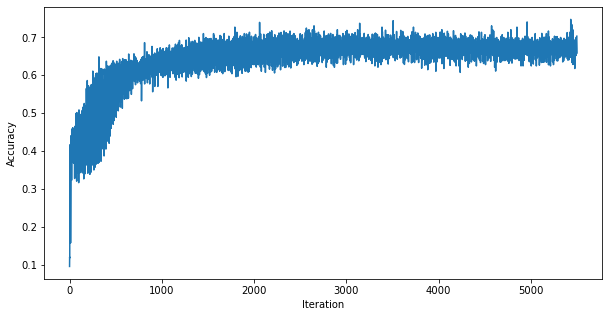

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

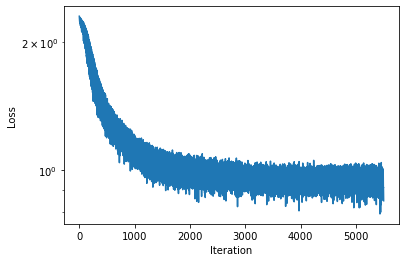

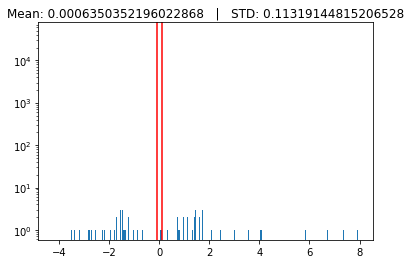

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 5.909090909090909


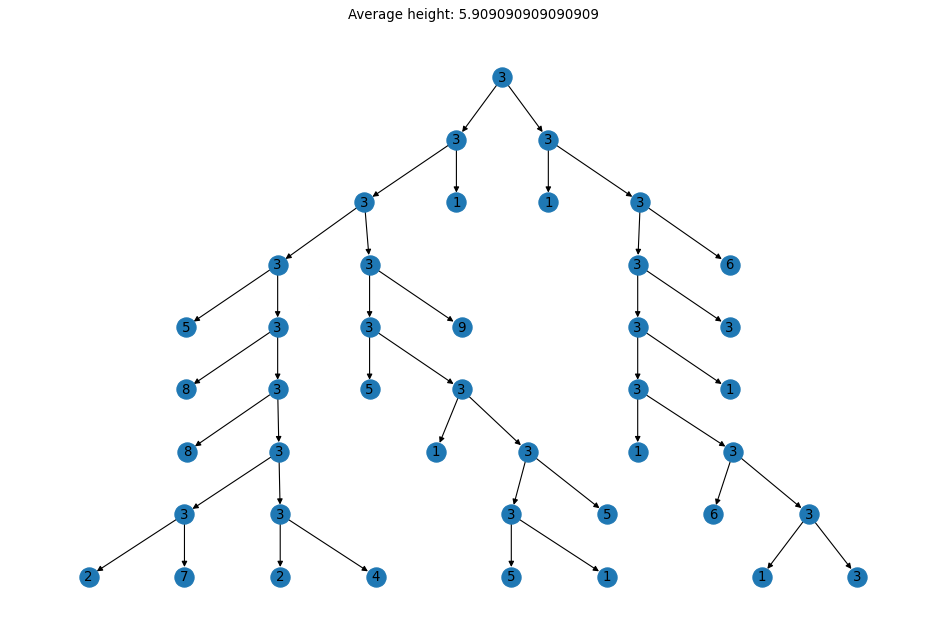

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 22


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
16338
============== Pattern 2 ==============
147
============== Pattern 3 ==============
1184
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
317
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
2307
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
Average comprehensibility: 29.90909090909091
std comprehensibility: 10.828871723772